# Top 5 Zipcodes to Invest In

## 1. Overview 
*fill in later*

##  2. Buisness Problem

A real estate investment firm centered in Philadelphia reached out to a consultant to help them figure out **"What are the top 5 best zip codes for us to invest in?"**.  The goal of the analysis in this notebook is to answer the stakeholder's question by reccomending the top 5 zipcodes to invest in the Philly Metro area *and* explain the logic behind those reccomendations.


----


## 3. Dataset
The dataset was origionally extracted from [Zillow Research](https://www.zillow.com/research/data/) and was taken from this [repo](https://github.com/learn-co-curriculum/dsc-phase-4-choosing-a-dataset/tree/main/time-series). 

Zillow is an website that advertises properties for rent or sale all over the USA. Due to it's easy accessability and expansive data collection throughout the USA, we chose to use this dataset to evaluate our data. In the raw data, we had **14,723** rows and **272** columns, but after changing the shape of our data so as to hace a seperate row for each unique zipcode and date we had **3,744,704** rows and **7** columns. The dataset covers from April 1996 through April 2018, and includes the median sales information for every month between those years. 

## Initial Look at the Data

### Imports 

In [1]:
#imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
# initial look at the raw data and importing the second column (with the zipcodes) as an object, not an integer
data = pd.read_csv("zillow_data.csv", dtype={'RegionName': object})
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(48), object(5)
memory usage: 30.6+ MB


## Data Preprocessing

We are going to get rid of the columns `RegionID` and `SizeRank` as they seem irrelevant to our current line of questioning. (We don't care about the size or region of the zipcodes we reccomend.) We are then going to reformat our data so we can look for and deal with any NaN's we may come across. 

In [4]:
data.drop(['RegionID', 'SizeRank'], axis=1, inplace=True)

In [5]:
data.head()

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,Chicago,IL,Chicago,Cook,334200.0,335400.0,336500.0,337600.0,338500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,235700.0,236900.0,236700.0,235400.0,233300.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,Katy,TX,Houston,Harris,210400.0,212200.0,212200.0,210700.0,208300.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,60614,Chicago,IL,Chicago,Cook,498100.0,500900.0,503100.0,504600.0,505500.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,79936,El Paso,TX,El Paso,El Paso,77300.0,77300.0,77300.0,77300.0,77400.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [6]:
# pulling out Philly data specifically 
phil_data = data.loc[data["Metro"]== "Philadelphia"]
phil_data

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
194,19111,Philadelphia,PA,Philadelphia,Philadelphia,84600.0,84500.0,84400.0,84200.0,84100.0,...,167100,168100,169300,170600,171900,172700,173200,174000,175200,175800
282,19124,Philadelphia,PA,Philadelphia,Philadelphia,43100.0,43000.0,42900.0,42700.0,42500.0,...,79800,80900,82200,83000,83800,84300,84200,84900,86700,88200
329,19446,Lansdale,PA,Philadelphia,Montgomery,155300.0,154900.0,154600.0,154200.0,153900.0,...,305400,307700,309200,309300,308800,308900,310100,311600,314000,315900
343,19020,Bensalem,PA,Philadelphia,Bucks,122000.0,121800.0,121600.0,121300.0,121000.0,...,250000,251600,252600,253800,255400,256400,257500,257600,255600,253400
351,19720,New Castle,DE,Philadelphia,New Castle,91300.0,92000.0,92600.0,93200.0,93600.0,...,173100,173200,172600,173400,178700,185200,189000,189400,184700,179000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13729,08026,Gibbsboro,NJ,Philadelphia,Camden,100500.0,100800.0,101100.0,101300.0,101500.0,...,174200,172800,173400,174300,174500,171100,166000,165200,171300,176600
14189,08067,Oldmans,NJ,Philadelphia,Salem,81300.0,81600.0,81900.0,82100.0,82400.0,...,145400,146400,147000,147200,147800,148400,147900,150500,158500,165900
14239,19453,Upper Providence,PA,Philadelphia,Montgomery,110100.0,109900.0,109700.0,109500.0,109300.0,...,210900,212100,212500,213700,215300,217500,220200,222400,223800,224800
14496,18915,Hatfield,PA,Philadelphia,Montgomery,165300.0,165300.0,165400.0,165400.0,165400.0,...,316500,318300,320200,321600,322000,322000,322700,323900,325700,327000


In [7]:
#checking for null values
phil_data[pd.isna(phil_data).any(axis=1)]

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04


In [8]:
# create metrics to judge return on investment (ROI)

# total ROI
phil_data['t_growth'] = (phil_data['2018-04'] - phil_data['1996-04']) / phil_data['1996-04']
# ROI pre-2008 crash 
phil_data['growth1'] = (phil_data['2007-09'] - phil_data['1996-04']) / phil_data['1996-04']
#ROI after 2008 crash 
phil_data['growth2'] = (phil_data['2018-04'] - phil_data['2011-03']) / phil_data['2011-03']
# re-check the info in a bit more manageable slice
phil_shortform = phil_data.loc[:,['RegionName','City','State','Metro','CountyName','t_growth','growth1','growth2']]
phil_shortform.head()

<ipython-input-8-d9de391fa1f0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phil_data['t_growth'] = (phil_data['2018-04'] - phil_data['1996-04']) / phil_data['1996-04']
<ipython-input-8-d9de391fa1f0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phil_data['growth1'] = (phil_data['2007-09'] - phil_data['1996-04']) / phil_data['1996-04']
<ipython-input-8-d9de391fa1f0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

,RegionName,City,State,Metro,CountyName,t_growth,growth1,growth2
194,19111,Philadelphia,PA,Philadelphia,Philadelphia,1.078014,1.141844,0.132003
282,19124,Philadelphia,PA,Philadelphia,Philadelphia,1.046404,1.125290,0.119289
329,19446,Lansdale,PA,Philadelphia,Montgomery,1.034127,1.020605,0.144151
343,19020,Bensalem,PA,Philadelphia,Bucks,1.077049,1.204918,0.109457
351,19720,New Castle,DE,Philadelphia,New Castle,0.960570,1.111720,0.198928


In [9]:
# checking for null values 
phil_data[pd.isna(phil_data).any(axis=1)]

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,t_growth,growth1,growth2


In [10]:
# re-check the info in a bit more manageable slice
phil_shortform.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281 entries, 194 to 14537
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionName  281 non-null    object 
 1   City        281 non-null    object 
 2   State       281 non-null    object 
 3   Metro       281 non-null    object 
 4   CountyName  281 non-null    object 
 5   t_growth    281 non-null    float64
 6   growth1     281 non-null    float64
 7   growth2     281 non-null    float64
dtypes: float64(3), object(5)
memory usage: 19.8+ KB


In [11]:
phil_shortform.describe()

,t_growth,growth1,growth2
count,281.000000,281.000000,281.000000
mean,1.086182,1.181123,0.114567
std,0.755744,0.430239,0.132367
min,0.237132,0.713235,-0.147526
25%,0.774878,1.004141,0.040498
50%,0.960227,1.108796,0.114919
75%,1.148588,1.209726,0.165386
max,7.046012,4.311475,1.059172


In [12]:
# find the top 5 zipcodes in Philadelphia who grew the most after the 2008 crash
phil_shortform.sort_values('growth2',ascending=False).head(5)

,RegionName,City,State,Metro,CountyName,t_growth,growth1,growth2
666,19145,Philadelphia,PA,Philadelphia,Philadelphia,4.155556,1.975309,1.059172
3615,19125,Philadelphia,PA,Philadelphia,Philadelphia,7.046012,3.288344,0.956003
518,19148,Philadelphia,PA,Philadelphia,Philadelphia,4.111922,2.481752,0.586858
940,19103,Philadelphia,PA,Philadelphia,Philadelphia,3.784584,2.756508,0.542373
784,19147,Philadelphia,PA,Philadelphia,Philadelphia,5.941176,4.105169,0.541568


In [13]:
# find the top 5 zipcodes who had the worst recovery after the crash
phil_shortform.sort_values('growth2',ascending=False).tail(5)

,RegionName,City,State,Metro,CountyName,t_growth,growth1,growth2
678,08021,Lindenwold,NJ,Philadelphia,Camden,0.471698,1.100236,-0.102804
12781,08063,National Park,NJ,Philadelphia,Gloucester,0.476942,1.134709,-0.107117
9024,19079,Sharon Hill,PA,Philadelphia,Delaware,0.425076,0.738532,-0.136237
8037,08079,Salem,NJ,Philadelphia,Salem,0.436765,1.039706,-0.139965
7613,08030,Gloucester City,NJ,Philadelphia,Camden,0.402458,1.227343,-0.147526


## Initial Visualizations 

Text(0, 0.5, 'Growth percentage')

<Figure size 432x288 with 0 Axes>

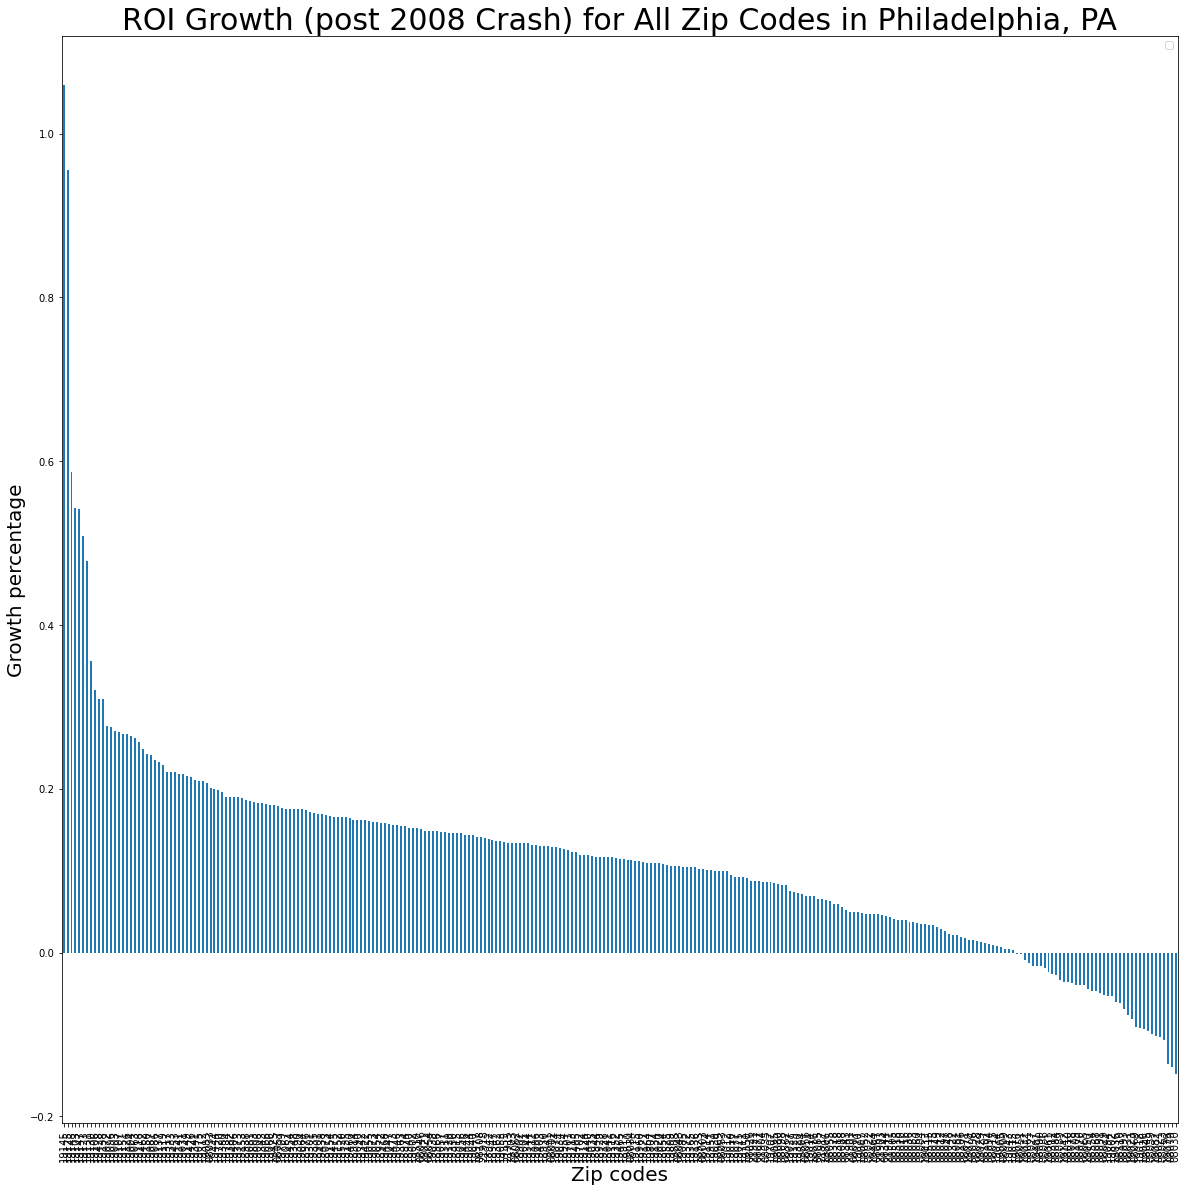

In [14]:
plt.gcf().autofmt_xdate()
phil_shortform[['RegionName','growth2']].sort_values(by='growth2',ascending=False).plot.bar(x='RegionName', y='growth2',figsize=(20,20))
plt.title('ROI Growth (post 2008 Crash) for All Zip Codes in Philadelphia, PA', fontsize=30)
plt.legend('')
plt.xlabel('Zip codes',fontsize=20)
plt.ylabel('Growth percentage',fontsize=20)
#plt.gcf().autofmt_xdate()

Text(0, 0.5, 'Growth percentage')

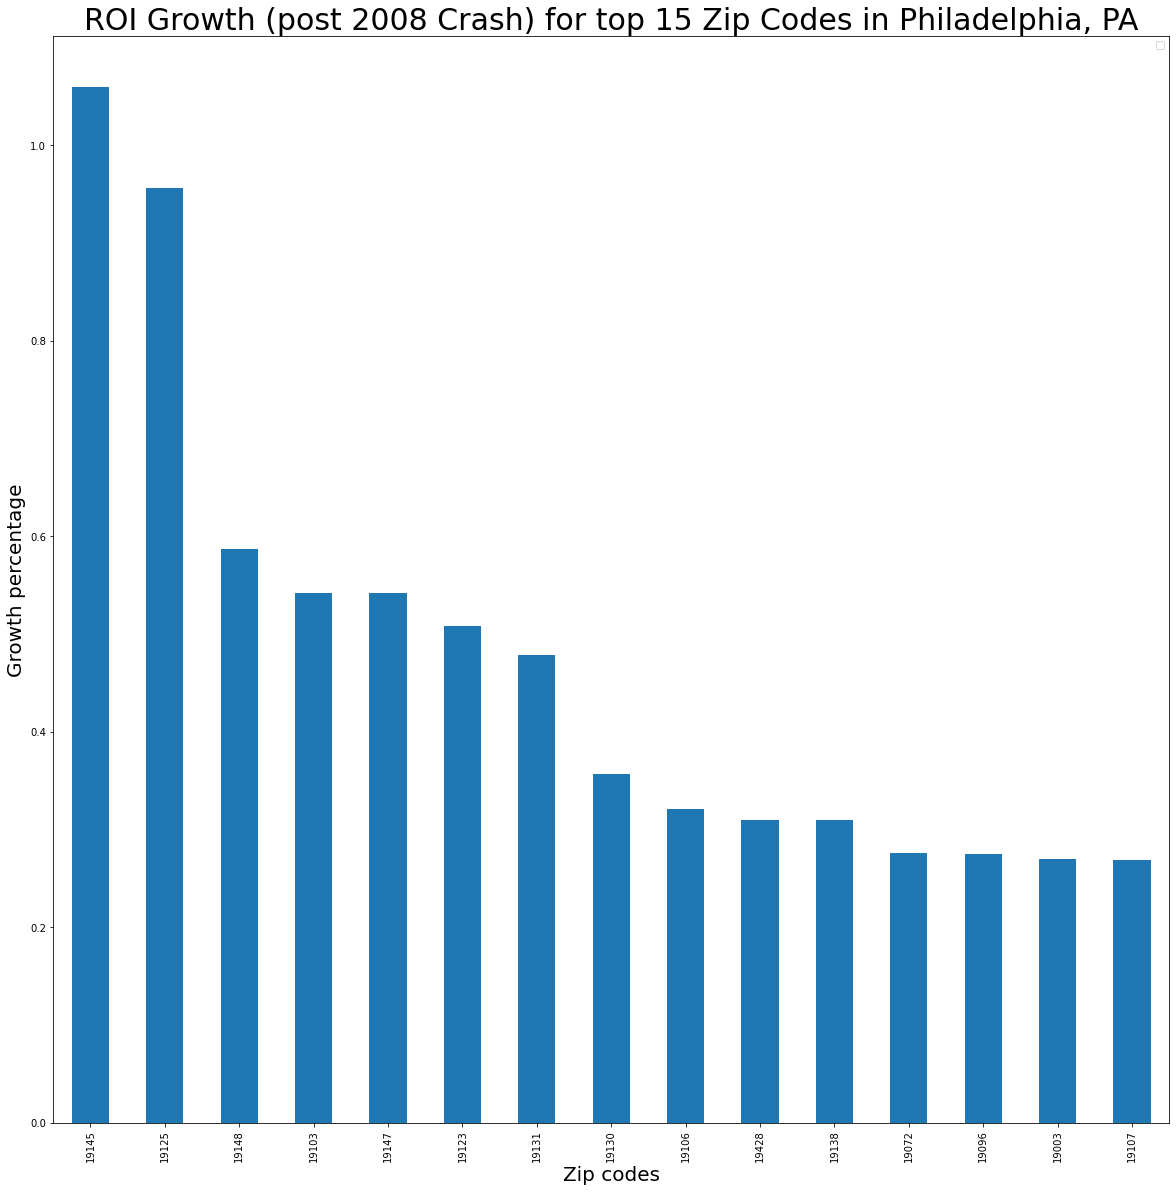

In [15]:
phil_shortform[['RegionName','growth2']].sort_values(by='growth2',ascending=False).head(15).plot.bar(x='RegionName', y='growth2',figsize=(20,20))
plt.title('ROI Growth (post 2008 Crash) for top 15 Zip Codes in Philadelphia, PA', fontsize=30)
plt.legend('')
plt.xlabel('Zip codes',fontsize=20)
plt.ylabel('Growth percentage',fontsize=20)

In [16]:
phil_data.head()

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,t_growth,growth1,growth2
194,19111,Philadelphia,PA,Philadelphia,Philadelphia,84600.0,84500.0,84400.0,84200.0,84100.0,...,170600,171900,172700,173200,174000,175200,175800,1.078014,1.141844,0.132003
282,19124,Philadelphia,PA,Philadelphia,Philadelphia,43100.0,43000.0,42900.0,42700.0,42500.0,...,83000,83800,84300,84200,84900,86700,88200,1.046404,1.125290,0.119289
329,19446,Lansdale,PA,Philadelphia,Montgomery,155300.0,154900.0,154600.0,154200.0,153900.0,...,309300,308800,308900,310100,311600,314000,315900,1.034127,1.020605,0.144151
343,19020,Bensalem,PA,Philadelphia,Bucks,122000.0,121800.0,121600.0,121300.0,121000.0,...,253800,255400,256400,257500,257600,255600,253400,1.077049,1.204918,0.109457
351,19720,New Castle,DE,Philadelphia,New Castle,91300.0,92000.0,92600.0,93200.0,93600.0,...,173400,178700,185200,189000,189400,184700,179000,0.960570,1.111720,0.198928


In [17]:
#pulling out the date columns so we can more easily change the format later on
dates = phil_data.loc[:, ~phil_data.columns.isin(['RegionName','City', 'State', 'Metro', 'CountyName', 't_growth', 'growth1', 'growth2'])]

In [18]:
# adjusting the column names so we can use pd.melt later
column_names_to_change = {}

for column in dates.columns:
    column_names_to_change[column] = f'{column}-01'
    
phil_data.rename(columns=column_names_to_change, inplace=True)

phil_data.head()

/Users/rachelsanderlin/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,RegionName,City,State,Metro,CountyName,1996-04-01,1996-05-01,1996-06-01,1996-07-01,1996-08-01,...,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,t_growth,growth1,growth2
194,19111,Philadelphia,PA,Philadelphia,Philadelphia,84600.0,84500.0,84400.0,84200.0,84100.0,...,170600,171900,172700,173200,174000,175200,175800,1.078014,1.141844,0.132003
282,19124,Philadelphia,PA,Philadelphia,Philadelphia,43100.0,43000.0,42900.0,42700.0,42500.0,...,83000,83800,84300,84200,84900,86700,88200,1.046404,1.125290,0.119289
329,19446,Lansdale,PA,Philadelphia,Montgomery,155300.0,154900.0,154600.0,154200.0,153900.0,...,309300,308800,308900,310100,311600,314000,315900,1.034127,1.020605,0.144151
343,19020,Bensalem,PA,Philadelphia,Bucks,122000.0,121800.0,121600.0,121300.0,121000.0,...,253800,255400,256400,257500,257600,255600,253400,1.077049,1.204918,0.109457
351,19720,New Castle,DE,Philadelphia,New Castle,91300.0,92000.0,92600.0,93200.0,93600.0,...,173400,178700,185200,189000,189400,184700,179000,0.960570,1.111720,0.198928


In [19]:
phil_data.iloc[:185]

,RegionName,City,State,Metro,CountyName,1996-04-01,1996-05-01,1996-06-01,1996-07-01,1996-08-01,...,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,t_growth,growth1,growth2
194,19111,Philadelphia,PA,Philadelphia,Philadelphia,84600.0,84500.0,84400.0,84200.0,84100.0,...,170600,171900,172700,173200,174000,175200,175800,1.078014,1.141844,0.132003
282,19124,Philadelphia,PA,Philadelphia,Philadelphia,43100.0,43000.0,42900.0,42700.0,42500.0,...,83000,83800,84300,84200,84900,86700,88200,1.046404,1.125290,0.119289
329,19446,Lansdale,PA,Philadelphia,Montgomery,155300.0,154900.0,154600.0,154200.0,153900.0,...,309300,308800,308900,310100,311600,314000,315900,1.034127,1.020605,0.144151
343,19020,Bensalem,PA,Philadelphia,Bucks,122000.0,121800.0,121600.0,121300.0,121000.0,...,253800,255400,256400,257500,257600,255600,253400,1.077049,1.204918,0.109457
351,19720,New Castle,DE,Philadelphia,New Castle,91300.0,92000.0,92600.0,93200.0,93600.0,...,173400,178700,185200,189000,189400,184700,179000,0.960570,1.111720,0.198928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8369,19317,Chadds Ford,PA,Philadelphia,Delaware,230000.0,230100.0,230200.0,230300.0,230500.0,...,465200,467400,468800,470100,473300,478100,481100,1.091739,1.035652,0.221066
8371,08093,Westville,NJ,Philadelphia,Gloucester,82900.0,82800.0,82700.0,82700.0,82700.0,...,129200,130500,133000,134900,135300,134100,132900,0.603136,1.095296,-0.068676
8414,19344,Honey Brook,PA,Philadelphia,Chester,133700.0,134000.0,134100.0,134300.0,134400.0,...,244400,245600,247200,248800,250600,253000,254700,0.905011,0.933433,0.133511
8431,21911,Rising Sun,MD,Philadelphia,Cecil,111600.0,111400.0,111200.0,111000.0,110700.0,...,223300,223300,223700,224700,226100,228000,229700,1.058244,1.386201,0.044091


In [20]:
# pulling out the top 5 zipcodes 
# Philly45 = phil_data.loc[(phil_data['RegionName'] == '19145')]
# Philly25 = phil_data.loc[(phil_data['RegionName'] == '19125')]
# Philly48 = phil_data.loc[(phil_data['RegionName'] == '19148')]
# Philly03 = phil_data.loc[(phil_data['RegionName'] == '19103')]
# Philly47 = phil_data.loc[(phil_data['RegionName'] == '19147')]


top_10_philly = phil_data.sort_values(by='growth2',ascending=False).head(10)
top_10_philly

,RegionName,City,State,Metro,CountyName,1996-04-01,1996-05-01,1996-06-01,1996-07-01,1996-08-01,...,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,t_growth,growth1,growth2
666,19145,Philadelphia,PA,Philadelphia,Philadelphia,40500.0,40500.0,40500.0,40500.0,40400.0,...,195900,197100,198000,199500,202500,206500,208800,4.155556,1.975309,1.059172
3615,19125,Philadelphia,PA,Philadelphia,Philadelphia,32600.0,32700.0,32800.0,32800.0,32900.0,...,253900,255700,257100,258000,258500,260500,262300,7.046012,3.288344,0.956003
518,19148,Philadelphia,PA,Philadelphia,Philadelphia,41100.0,41100.0,41000.0,40900.0,40700.0,...,198600,199700,201000,202000,203800,207400,210100,4.111922,2.481752,0.586858
940,19103,Philadelphia,PA,Philadelphia,Philadelphia,195900.0,196800.0,197600.0,198400.0,199100.0,...,888500,898900,905000,909200,918200,930400,937300,3.784584,2.756508,0.542373
784,19147,Philadelphia,PA,Philadelphia,Philadelphia,56100.0,55600.0,55000.0,54500.0,54000.0,...,376600,377600,377400,378000,381200,386400,389400,5.941176,4.105169,0.541568
5214,19123,Philadelphia,PA,Philadelphia,Philadelphia,61000.0,60600.0,60300.0,59900.0,59600.0,...,392500,394900,397700,400600,403500,406700,409300,5.709836,4.311475,0.508662
531,19131,Philadelphia,PA,Philadelphia,Philadelphia,36700.0,36700.0,36800.0,36900.0,37000.0,...,83200,86600,90300,93600,95500,97000,98600,1.686649,1.130790,0.478261
1807,19130,Philadelphia,PA,Philadelphia,Philadelphia,76600.0,76700.0,76700.0,76600.0,76500.0,...,419000,422500,425600,428500,429700,429400,428700,4.596606,3.567885,0.356646
5510,19106,Philadelphia,PA,Philadelphia,Philadelphia,298900.0,298900.0,298900.0,298800.0,298700.0,...,1025300,1042700,1058500,1066200,1069800,1081700,1095700,2.665775,2.334560,0.321075
4747,19428,Conshohocken,PA,Philadelphia,Montgomery,114800.0,114800.0,114700.0,114700.0,114700.0,...,314700,313400,312900,313400,314500,316500,318400,1.773519,1.267422,0.310288


In [21]:
def after_crash(df):
    #reduce data so we only will see the dates/values after the market recoved from the 2008 crash
    df_after_crash = df.drop(df.columns[5:185], axis=1,inplace=True)  
    return df_after_crash


after_crash(top_10_philly)
top_10_philly

,RegionName,City,State,Metro,CountyName,2011-04-01,2011-05-01,2011-06-01,2011-07-01,2011-08-01,...,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,t_growth,growth1,growth2
666,19145,Philadelphia,PA,Philadelphia,Philadelphia,101400.0,100400.0,98100.0,96600.0,95700.0,...,195900,197100,198000,199500,202500,206500,208800,4.155556,1.975309,1.059172
3615,19125,Philadelphia,PA,Philadelphia,Philadelphia,132300.0,129400.0,126500.0,124400.0,122900.0,...,253900,255700,257100,258000,258500,260500,262300,7.046012,3.288344,0.956003
518,19148,Philadelphia,PA,Philadelphia,Philadelphia,130100.0,127500.0,124200.0,121300.0,119300.0,...,198600,199700,201000,202000,203800,207400,210100,4.111922,2.481752,0.586858
940,19103,Philadelphia,PA,Philadelphia,Philadelphia,605700.0,605100.0,599600.0,595200.0,596300.0,...,888500,898900,905000,909200,918200,930400,937300,3.784584,2.756508,0.542373
784,19147,Philadelphia,PA,Philadelphia,Philadelphia,251100.0,249600.0,248500.0,248900.0,250900.0,...,376600,377600,377400,378000,381200,386400,389400,5.941176,4.105169,0.541568
5214,19123,Philadelphia,PA,Philadelphia,Philadelphia,268600.0,262000.0,254900.0,251600.0,251900.0,...,392500,394900,397700,400600,403500,406700,409300,5.709836,4.311475,0.508662
531,19131,Philadelphia,PA,Philadelphia,Philadelphia,66200.0,65800.0,66100.0,66500.0,66800.0,...,83200,86600,90300,93600,95500,97000,98600,1.686649,1.130790,0.478261
1807,19130,Philadelphia,PA,Philadelphia,Philadelphia,316300.0,315000.0,311400.0,308200.0,306900.0,...,419000,422500,425600,428500,429700,429400,428700,4.596606,3.567885,0.356646
5510,19106,Philadelphia,PA,Philadelphia,Philadelphia,825800.0,826600.0,821800.0,815800.0,814200.0,...,1025300,1042700,1058500,1066200,1069800,1081700,1095700,2.665775,2.334560,0.321075
4747,19428,Conshohocken,PA,Philadelphia,Montgomery,241700.0,240200.0,239700.0,239300.0,238100.0,...,314700,313400,312900,313400,314500,316500,318400,1.773519,1.267422,0.310288


In [22]:
def melt_data(df):
    # melting the data so we have it in the long version, instead of wide
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName', 't_growth', 'growth1', 'growth2'], var_name='time')
    # makeing our new column `time` a datetime variable 
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    # getting rid of rows that are missing `value` values
    melted_nonan = melted.dropna(subset=['value'])
    #set `time` as index so we can model it as a time series dataset
    melted_nonan.set_index('time',inplace=True)
    # drop all the columns we no longer need
    melted_nonan.drop(labels = ['RegionName', 'City', 'State', 'Metro', 'CountyName', 't_growth', 'growth1', 'growth2'], axis=1, inplace=True)
    return  melted_nonan


In [23]:
zip_list = []
for zip_code in top_10_philly['RegionName']:
    zip_list.append(zip_code)
zip_list

['19145',
 '19125',
 '19148',
 '19103',
 '19147',
 '19123',
 '19131',
 '19130',
 '19106',
 '19428']

In [24]:

top_10_melt = []
for zip_code in top_10_philly['RegionName']:
     top_10_melt.append({
         'zip_code': zip_code,
         'data': melt_data(top_10_philly.loc[(top_10_philly['RegionName'] == zip_code)])
     })
    
top_10_melt[0]['data']

,value
time,
2011-04-01,101400.0
2011-05-01,100400.0
2011-06-01,98100.0
2011-07-01,96600.0
2011-08-01,95700.0
...,...
2017-12-01,198000.0
2018-01-01,199500.0
2018-02-01,202500.0


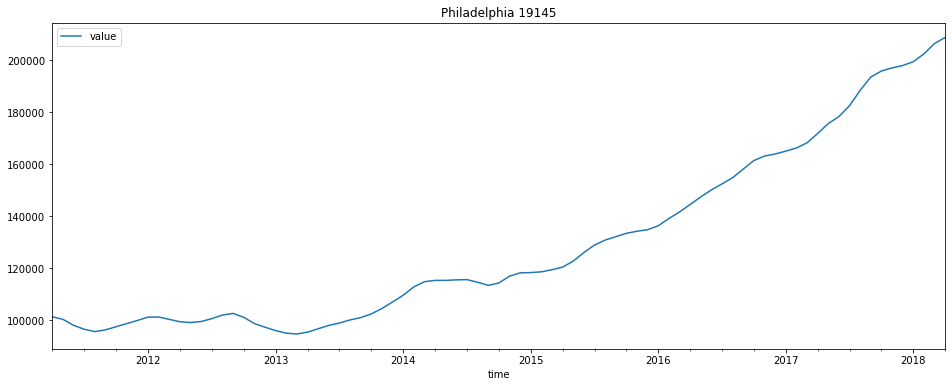

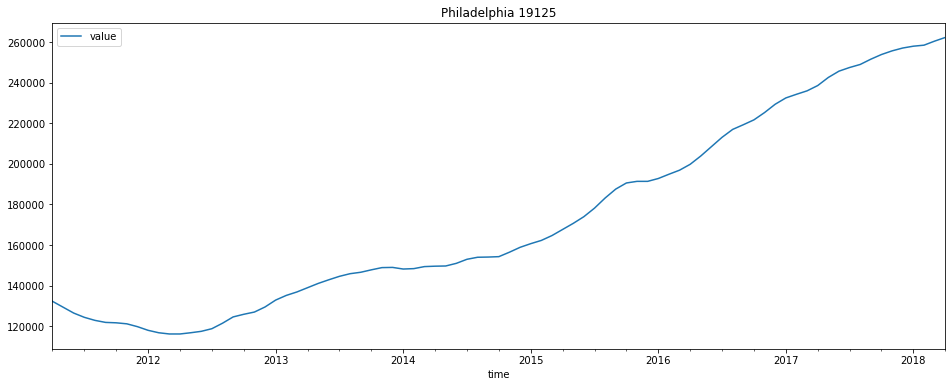

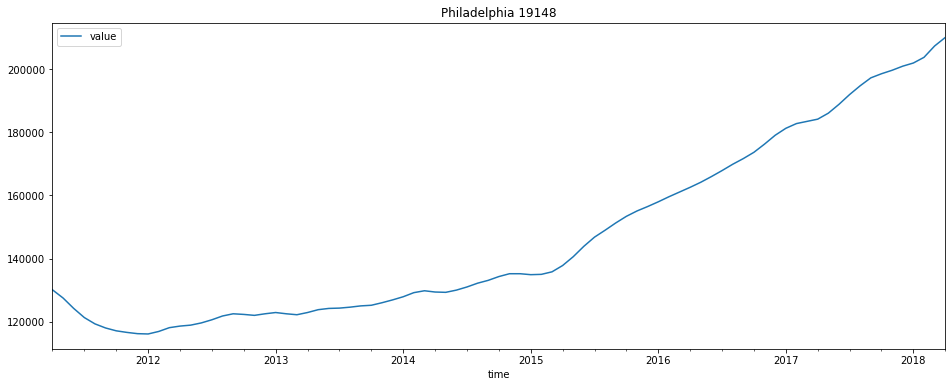

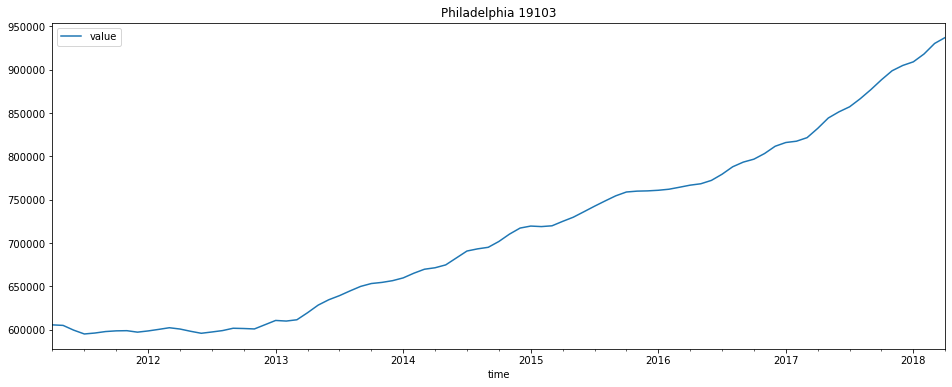

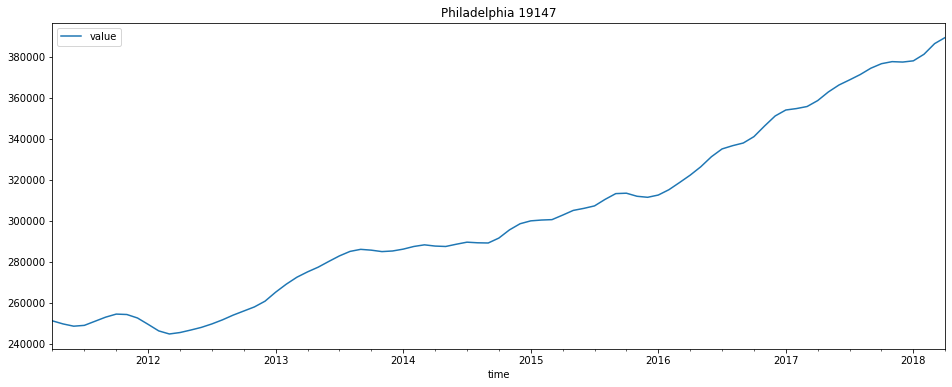

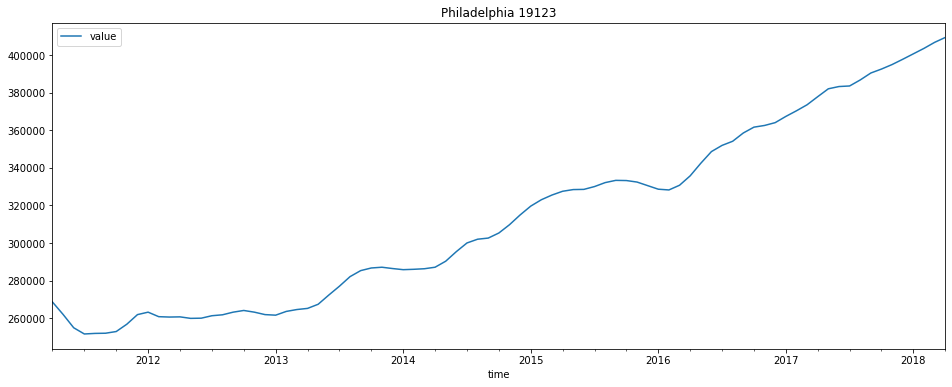

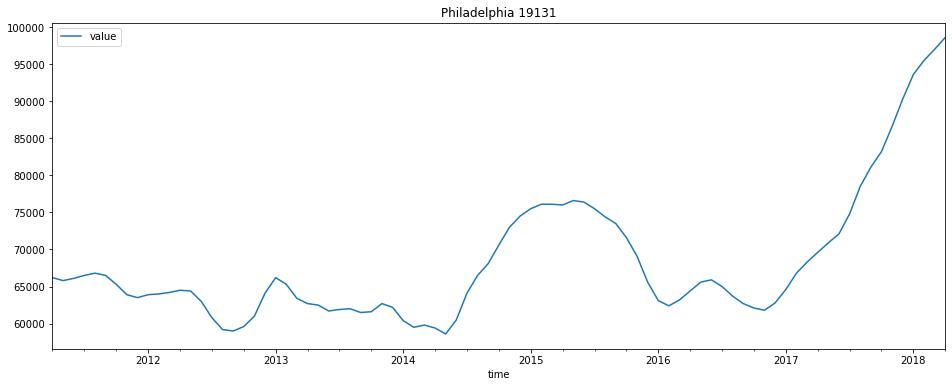

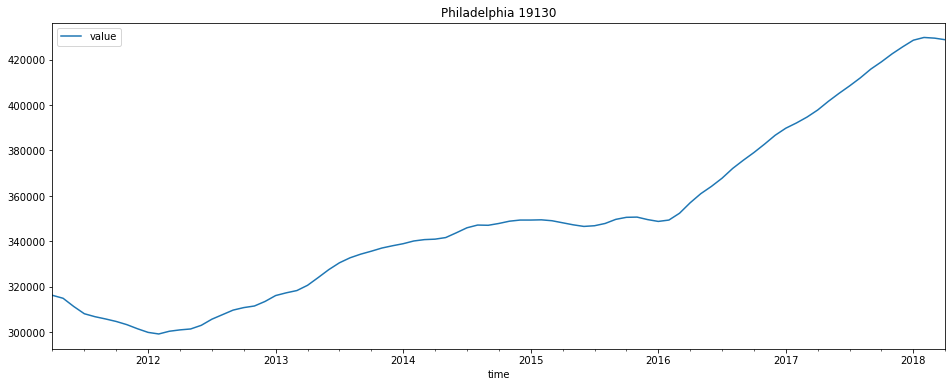

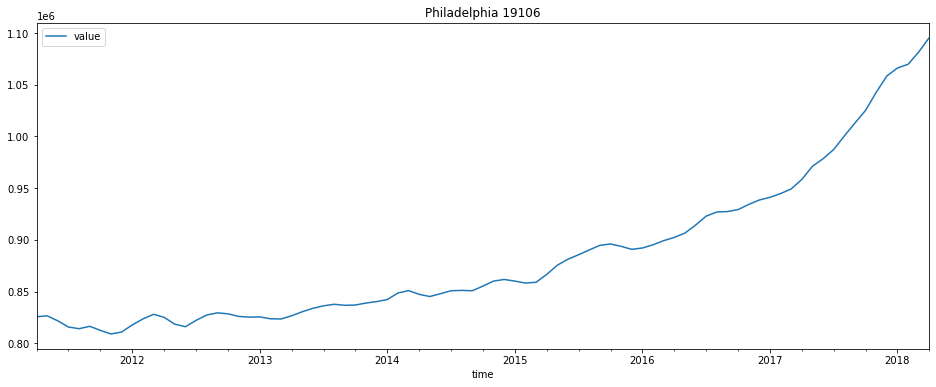

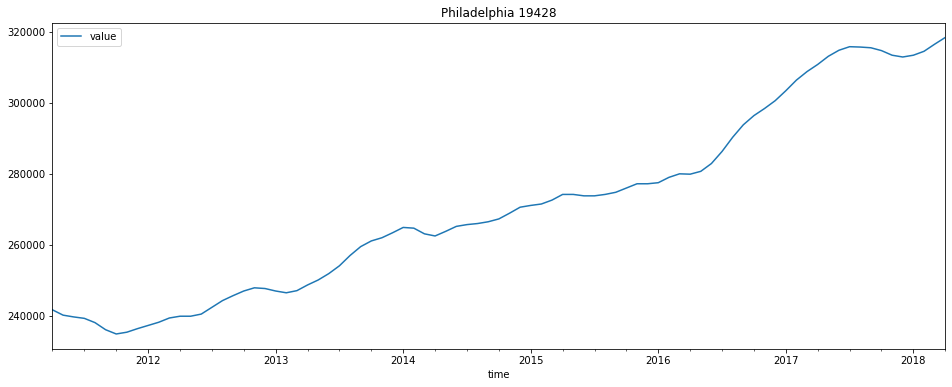

In [25]:
for zip_code_melt in top_10_melt:
    zip_code_melt['data'].plot(title=  f"Philadelphia {zip_code_melt['zip_code']}", figsize = (16,6));

<ipython-input-44-2973cec9bdec>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 200000, 400000, 600000, 800000, 1000000])


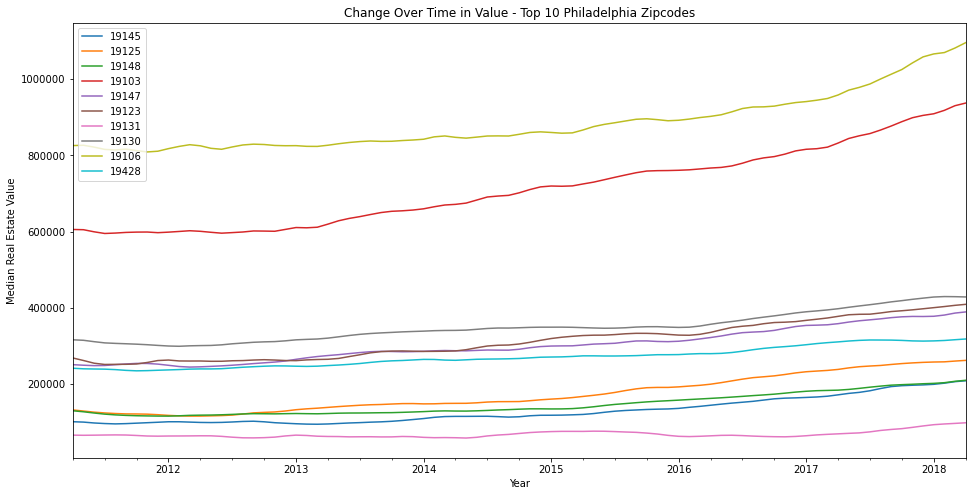

In [44]:

ax = top_10_melt[0]['data'].plot(figsize = (16,8))

for i in range(1, 10):
    top_10_melt[i]['data'].plot(ax=ax)
ax.set_yticklabels([0, 200000, 400000, "600,000", "800,000", "1,000,000"])
ax.set_xlabel("Year")
ax.set_ylabel("Median Real Estate Value ($)")
plt.title('Change Over Time in Value - Top 10 Philadelphia Zipcodes')
ax.legend(zip_list);